In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def lorenz_system(state, t, sigma, rho, beta):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

In [9]:
# Set parameters
sigma = 10
rho = 28
beta = 8/3

# Set initial conditions
initial_state = [1, 1, 1]

# Create time points
t = np.linspace(0, 100, 10000)

# Solve the ODE
solution = odeint(lorenz_system, initial_state, t, args=(sigma, rho, beta))

# Extract x, y, z coordinates
x, y, z = solution.T

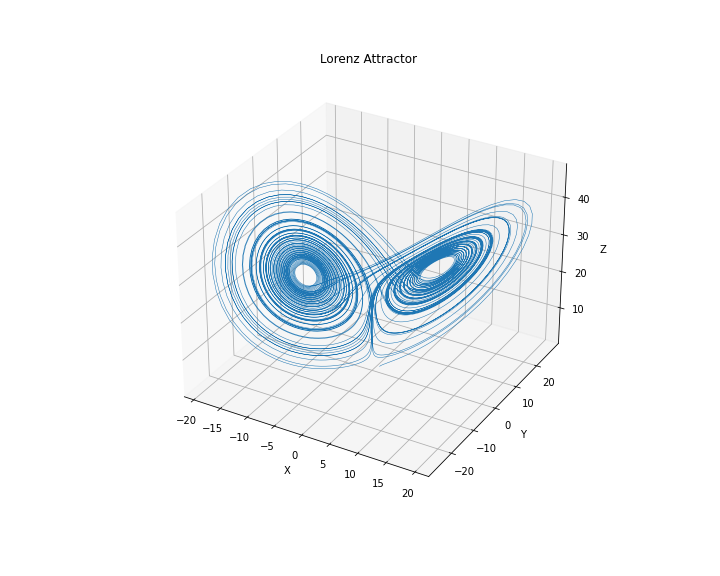

In [10]:
%matplotlib inline
%matplotlib ipympl

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor')

plt.show()

In [11]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(20200305)

### Intro to state space models

In the univariate tutorial we saw how to model time series as regression plus a local level model, using variational inference. This tutorial covers a different way to model time series: state space models and exact inference. Pyro’s forecasting module allows these two paradigms to be combined, for example modeling seasonality with regression, including a slow global trend, and using a state-space model for short-term local trend.

Pyro implements a few state space models, but the most important are the GaussianHMM distribution and its heavy-tailed generalization the LinearHMM distribution. Both of these model a linear dynamical system with hidden state; both are multivariate, and both allow learning of all process parameters. On top of these the pyro.contrib.timeseries module implements a variety of multivariate Gaussian Process models that compile down to GaussianHMMs.

Pyro’s inference for GaussianHMM uses parallel-scan Kalman filtering, allowing fast analysis of very long time series. Similarly, Pyro’s inference for LinearHMM uses entirely parallel auxiliary variable methods to reduce to a GaussianHMM, which then permits parallel-scan inference. Thus both methods allow parallelization of long time series analysis, even for a single univariate time series.

Let’s again look at the BART train ridership dataset:

In [12]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

/opt/conda/lib/python3.8/site-packages/pyro/contrib/examples/bart.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(pkl_file)


dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


torch.Size([78888, 1])


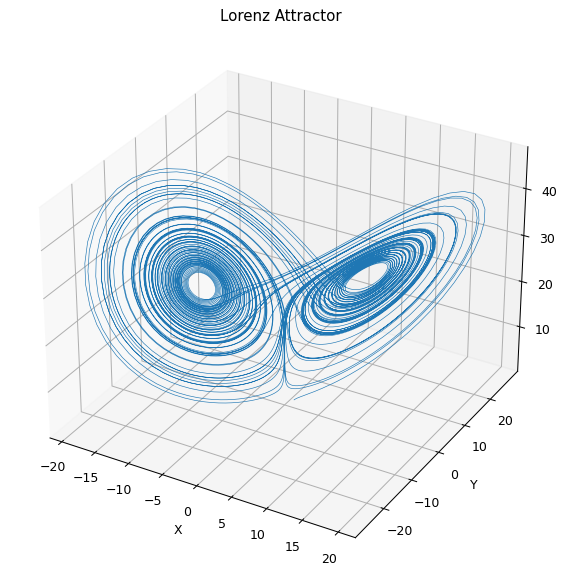

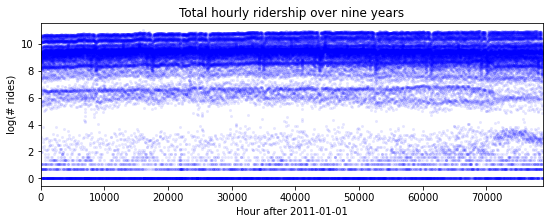

In [13]:
data = dataset["counts"].sum([-1, -2]).unsqueeze(-1).log1p()
print(data.shape)
plt.figure(figsize=(9, 3))
plt.plot(data, 'b.', alpha=0.1, markeredgewidth=0)
plt.title("Total hourly ridership over nine years")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(0, len(data));

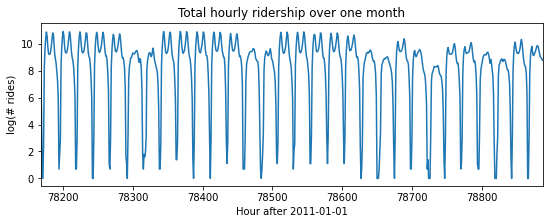

In [14]:
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total hourly ridership over one month")
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(len(data) - 24 * 30, len(data));

### GaussianHMM

Let’s start by modeling hourly seasonality together with a local linear trend, where we model seasonality via regression and local linear trend via a GaussianHMM. This noise model includes a mean-reverting hidden state (an Ornstein-Uhlenbeck process) plus Gaussian observation noise.

In [16]:
T0 = 0                # beginning
T2 = data.size(-2)    # end
T1 = T2 - 24 * 7 * 2  # train/test split
means = data[:T1 // (24 * 7) * 24 * 7].reshape(-1, 24 * 7).mean(0)

In [17]:
class Model1(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)

        # We'll hard-code the periodic part of this model, learning only the local model.
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        # On top of this mean prediction, we'll learn a linear dynamical system.
        # This requires specifying five pieces of data, on which we will put structured priors.
        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)

        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        # Note timescale is a scalar but we need a 1x1 transition matrix (hidden_dim=1),
        # thus we unsqueeze twice using [..., None, None].
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)

        # Note the obs_matrix has shape hidden_dim x obs_dim = 1 x 1.
        obs_matrix = torch.tensor([[1.]])
        obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)

        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

We can then train the model on many years of data. Note that because we are being variational about only time-global variables, and exactly integrating out time-local variables (via GaussianHMM), stochastic gradients are very low variance; this allows us to use a large learning rate and few steps.

In [18]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 0.878717
INFO 	 step  100 loss = 0.650654
INFO 	 step  200 loss = 0.650484
INFO 	 step  300 loss = 0.650567


timescale = 4.35
trans_scale = 0.4604
obs_scale = 0.02392
CPU times: user 2min 21s, sys: 179 ms, total: 2min 21s
Wall time: 2min 38s


Plotting forecasts of the next two weeks of data, we see mostly reasonable forecasts, but an anomaly on Christmas when rides were overpredicted. This is to be expected, as we have not modeled yearly seasonality or holidays.

In [ ]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

Next let’s change the model to use heteroskedastic observation noise, depending on the hour of week.

In [ ]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        duration = zero_data.size(-2)
        prediction = periodic_repeat(means, duration, dim=-1).unsqueeze(-1)

        init_dist = dist.Normal(0, 10).expand([1]).to_event(1)
        timescale = pyro.sample("timescale", dist.LogNormal(math.log(24), 1))
        trans_matrix = torch.exp(-1 / timescale)[..., None, None]
        trans_scale = pyro.sample("trans_scale", dist.LogNormal(-0.5 * math.log(24), 1))
        trans_dist = dist.Normal(0, trans_scale.unsqueeze(-1)).to_event(1)
        obs_matrix = torch.tensor([[1.]])

        # To model heteroskedastic observation noise, we'll sample obs_scale inside a plate,
        # then repeat to full duration. This is the only change from Model1.
        with pyro.plate("hour_of_week", 24 * 7, dim=-1):
            obs_scale = pyro.sample("obs_scale", dist.LogNormal(-2, 1))
        obs_scale = periodic_repeat(obs_scale, duration, dim=-1)

        obs_dist = dist.Normal(0, obs_scale.unsqueeze(-1)).to_event(1)
        noise_dist = dist.GaussianHMM(
            init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist, duration=duration)
        self.predict(noise_dist, prediction)

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
covariates = torch.zeros(len(data), 0)  # empty
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1, num_steps=400)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

Note this gives us a much longer timescale and thereby more accurate short-term predictions:

In [ ]:
samples = forecaster(data[:T1], covariates, num_samples=100)
samples.clamp_(min=0)  # apply domain knowledge: the samples must be positive
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 7, T2)
plt.text(78732, 3.5, "Christmas", rotation=90, color="green")
plt.legend(loc="best");

In [ ]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1 - 24 * 7, T2),
         data[T1 - 24 * 7: T2], 'k-', label='truth')
plt.title("Total hourly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Hour after 2011-01-01")
plt.xlim(T1 - 24 * 2, T1 + 24 * 4)
plt.legend(loc="best");

### Heavy-tailed modeling with LinearHMM

Next let’s change our model to a linear-Stable dynamical system, exhibiting learnable heavy tailed behavior in both the process noise and observation noise. As we’ve already seen in the univariate tutorial, this will require special handling of stable distributions by poutine.reparam(). For state space models, we combine LinearHMMReparam with other reparameterizers like StableReparam and SymmetricStableReparam. All reparameterizers preserve behavior of the generative model, and only serve to enable inference via auxiliary variable methods.